In [1]:
import torch
import cv2
import matplotlib.pyplot as plt

from gaussian_splatting.colmap import parse_cameras, parse_images, parse_points3d, clean_text

In [2]:
dataset = "hotdog"

In [3]:
# parsing colmap output
with open(f"../data/{dataset}/cameras.txt", "r")  as f:
    cameras = parse_cameras(clean_text(f.readlines()))

with open(f"../data/{dataset}/points3D.txt", "r")  as f:
    points3d = parse_points3d(clean_text(f.readlines()))

with open(f"../data/{dataset}/images.txt", "r")  as f:
    images = parse_images(clean_text(f.readlines()), cameras, points3d)

# loading original images as nd arrays
original_images = {}
for image in images.values():
    im = cv2.imread(f"../data/{dataset}/images/{image.name}")[:, :, ::-1] / 256
    original_images[image.idx] = im

In [4]:
from gaussian_splatting.loss import DSSIM

ssim_loss = DSSIM
l1_loss = lambda img1, img2: torch.abs(img1 - img2).mean()

In [5]:
# putting images in the gpu
original_images_gpu = {
    key: torch.tensor(value, dtype=torch.float, device="cuda").permute(2, 0, 1)
    for key, value in original_images.items()
}

images = [*original_images_gpu.values()]

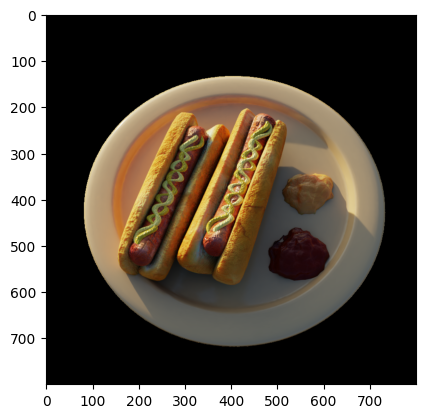

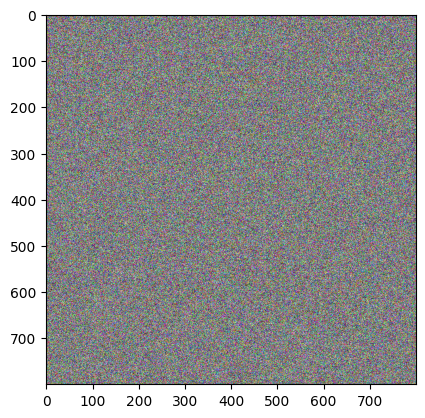

epoch 0, loss: 0.9961338639259338
epoch 10, loss: 0.9700261354446411
epoch 20, loss: 0.942238450050354
epoch 30, loss: 0.8992490172386169
epoch 40, loss: 0.7855992317199707
epoch 50, loss: 0.6811503171920776
epoch 60, loss: 0.6072338223457336
epoch 70, loss: 0.5708721876144409
epoch 80, loss: 0.5462848544120789


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch 90, loss: 0.5302091240882874


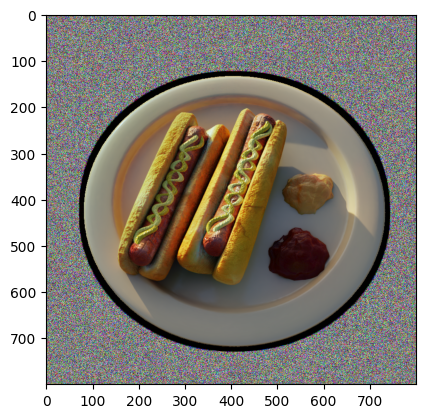

In [10]:
# validating my ssim loss...
image = [*original_images_gpu.values()][0].clone()
approx = torch.rand_like(image, dtype=torch.float, device="cuda", requires_grad=True)

plt.imshow(image.clone().cpu().detach().numpy().transpose([1, 2, 0]))
plt.show()

plt.imshow(approx.clone().cpu().detach().numpy().transpose([1, 2, 0]))
plt.show()

_lambda = 1
criterion = lambda img1, img2: (1 - _lambda) * l1_loss(img1, img2) + _lambda * ssim_loss(img1, img2)
optimizer = torch.optim.Adam([approx], 0.01)
for epoch in range(100):
    optimizer.zero_grad()
    loss = criterion(image, approx)
    loss.backward()
    optimizer.step()
    if epoch%10 == 0:
        print(f"epoch {epoch}, loss: {loss}")

plt.imshow(approx.clone().cpu().detach().numpy().transpose([1, 2, 0]))
plt.show()
